# Does replaying the same movie clip reduce the variability of resting-state fMRI?

In [28]:
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pathlib import Path
from bids import BIDSLayout

## Load the functional connectivity matrices

(2080, 36)


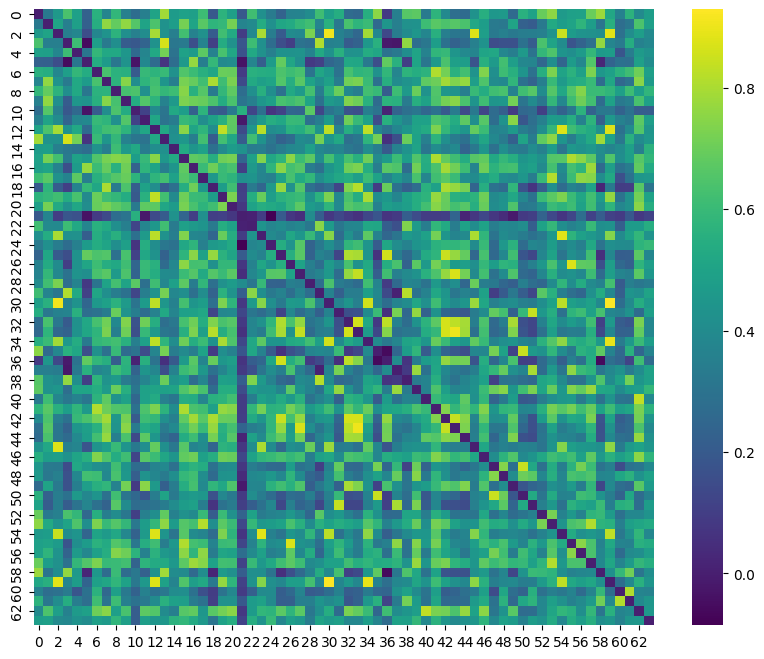

In [29]:
# Keep only upper-triangle since the FC matrix is symmetric (does the diagonal of our FC contain only ones ? if yes can discard the diagonal, if not have to keep it 
fc_path = Path("/data/derivatives/hcph-derivatives-rsmovie/functional_connectivity/DiFuMo64-LP/sub-001")
# Initialize the BIDS layout
layout = BIDSLayout(fc_path, validate=False)

# Get all the files matching the pattern
files = layout.get(subject='001', task='rsmovie', suffix='connectivity', extension='tsv', return_type='file')

# Meas is not a recognized entity by PyBIDS, so I am filtering for meas-connectivity separately
# Keep only files with 'meas-correlation' in the filename
files = [f for f in files if 'meas-correlation' in f]
assert len(files) == 36, f"Expected 36 FC matrices, got {len(files)}"

# Load the data from each file and concatenate
fc_matrices = []
for file in files:
    fc_matrix = pd.read_csv(file, sep='\t', header=None)
    fc_matrices.append(fc_matrix.values[np.triu_indices_from(fc_matrix, k=0)])

# Store the matrix size for reconstruction later
fc_size = fc_matrix.shape[0]
# Concatenate all the upper triangle values
fc_concat = np.vstack(fc_matrices)
# Transport matrix
fc_concat = fc_concat.T

#Plot an example FC matrix
plt.figure(figsize=(10, 8))
sns.heatmap(fc_matrix, cmap='viridis')

# Generate a random matrix of size 2080x36
#fc_concat = np.random.rand(2080, 36)
print(fc_concat.shape)

## Run PCA to estimate the residual variance for each rsfMRI run

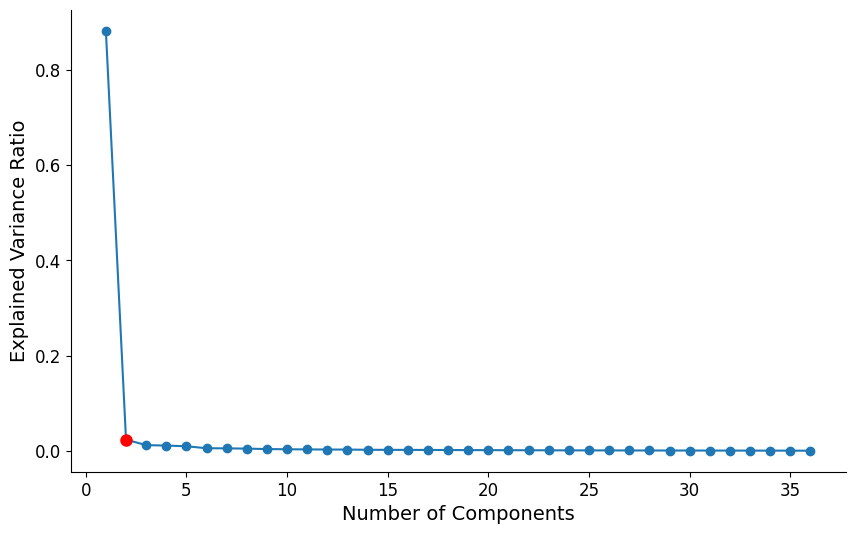

In [30]:
from sklearn.decomposition import PCA

# Run PCA
# Center the data by removing the mean from each session
fc_concat = fc_concat - np.mean(fc_concat, axis=0)

# Standardize the data to have unit variance
fc_concat = fc_concat / np.std(fc_concat, axis=0)

# Run PCA
pca = PCA()
pca.fit(fc_concat)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Generate the elbow plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
ax.set_xlabel('Number of Components', fontsize=14)
ax.set_ylabel('Explained Variance Ratio', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Define the number of components to keep
n_comp = 2

# Highlight the points corresponding to number of components we keep in red
ax.plot(n_comp, explained_variance[n_comp-1], marker='o', markersize=8, color='red')

plt.show()

We are using the elbow plot to decide the number of principal components to keep.

In [31]:
# Calculate the eigenvalues from the explained variance
eigenvalues = pca.explained_variance_
print(f"Eigenvalues: {eigenvalues}")   

# Apply the Kaiser criterion
n_comp_kaiser = np.sum(eigenvalues > 1)
print(f"Number of components according to the Kaiser criterion: {n_comp_kaiser}")

Eigenvalues: [3.17454034e+01 8.53859103e-01 4.37869786e-01 4.06409268e-01
 3.52139329e-01 2.04805620e-01 1.93578523e-01 1.75510372e-01
 1.41090321e-01 1.26289518e-01 1.15498815e-01 1.06072135e-01
 1.02867332e-01 8.59980002e-02 8.18426945e-02 7.76877571e-02
 7.41371634e-02 6.90253653e-02 6.20227050e-02 5.94006019e-02
 5.54126482e-02 5.16116212e-02 4.69416557e-02 4.21943525e-02
 4.06102254e-02 3.98111140e-02 3.50395967e-02 3.36418607e-02
 3.15534957e-02 3.07715631e-02 2.76547874e-02 2.64417427e-02
 2.40418825e-02 2.28930564e-02 2.14094515e-02 1.57791984e-02]
Number of components according to the Kaiser criterion: 1


## Reconstruct the FC with a limited number of components

After extracting the principal components, each FC matrix can be expressed as a linear combinations of the principal components plus a residual matrix.

In [32]:
print(pca.components_.shape)
# Project PC components back into each FC subject space
fc_projected = pca.transform(fc_concat)[:, :n_comp]
print(fc_projected.shape)
fc_reconstructed = np.dot(fc_projected, pca.components_[:n_comp, :]) + np.mean(fc_concat, axis=0)
print(fc_reconstructed.shape)

(36, 36)
(2080, 2)
(2080, 36)


## Compute the residual matrix

In [33]:
# Calculate the residuals as the difference between the full and reconstructed FC matrices
residuals = fc_concat - fc_reconstructed
print(residuals.shape)

(2080, 36)


In [34]:
import numpy as np
from sklearn.decomposition import PCA

# Project the data onto the residual components (from n_comp + 1 onwards)
residuals_frompc = pca.transform(fc_concat)[:, n_comp:]

# Reconstruct the data using the residual components
residuals_frompc = np.dot(residuals_frompc, pca.components_[n_comp:, :]) + np.mean(fc_concat, axis=0)

# Print the shape of the reconstructed data
print(residuals_frompc.shape)


(2080, 36)


## Plot residual matrix

In [35]:
# Function to reconstruct the full matrix from the upper triangle
def reconstruct_full_matrix(upper_triangle, size):
    full_matrix = np.zeros((size, size))
    upper_indices = np.triu_indices(size)
    full_matrix[upper_indices] = upper_triangle
    full_matrix = full_matrix + full_matrix.T - np.diag(np.diag(full_matrix))
    return full_matrix

# Test my reconstruction function
upper_triangle = fc_matrix.values[np.triu_indices_from(fc_matrix, k=0)]
full_matrix = reconstruct_full_matrix(upper_triangle, fc_size)
full_matrix.shape
assert np.array_equal(full_matrix, fc_matrix.values)

[-0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393]


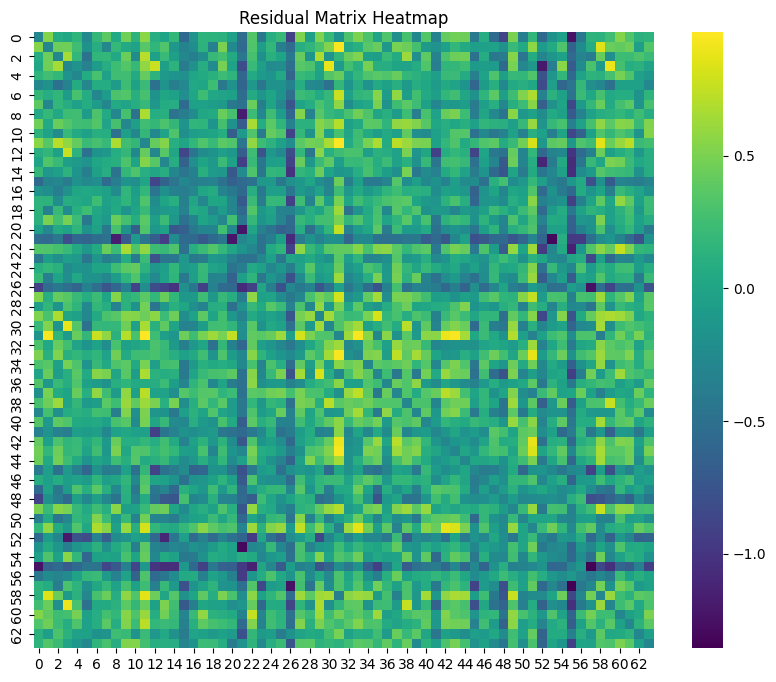

In [36]:
residual = reconstruct_full_matrix(residuals[:,0], fc_size)
print(np.diag(residual))

# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

[-0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393]


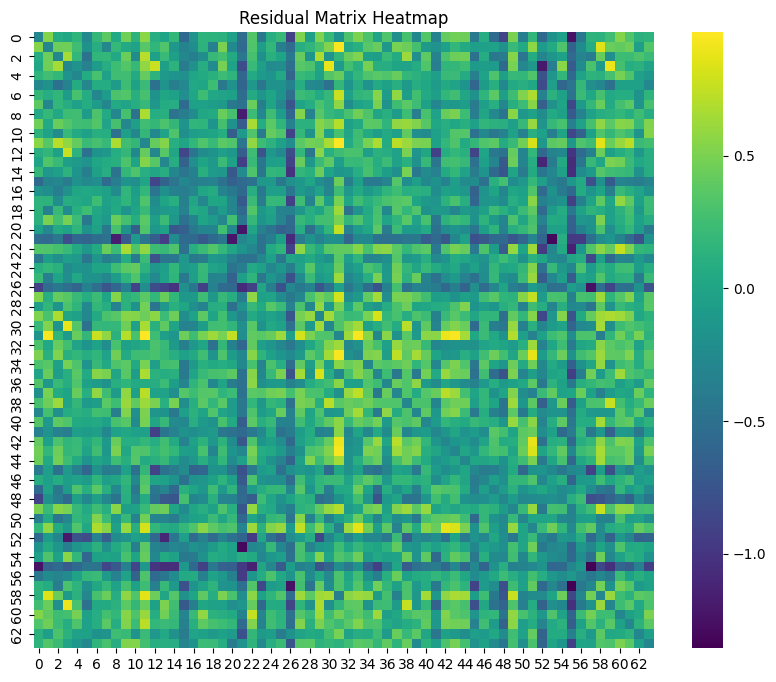

In [37]:
# Assuming the size of the original FC matrix is 64x64
size = 64
residual_frompc = reconstruct_full_matrix(residuals_frompc[:,0], size)
print(np.diag(residual))

# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual_frompc, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

## Plot the variance of the residuals over sessions

(36,)


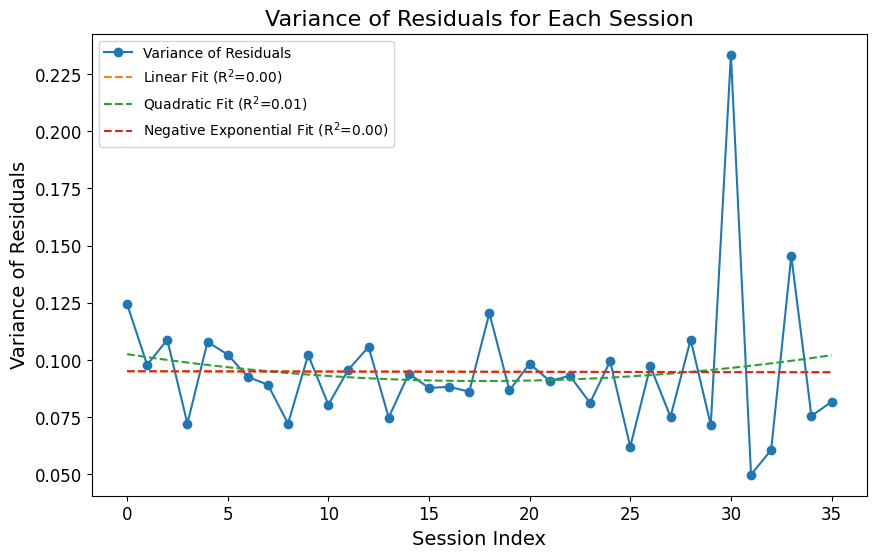

In [38]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Compute the variance of the residuals for each session
residuals_var = np.var(residuals, axis=0)
print(residuals_var.shape)

# Plot the variance of the residuals as a function of the session index
plt.figure(figsize=(10, 6))
plt.plot(range(len(residuals_var)), residuals_var, marker='o', linestyle='-', label='Variance of Residuals')

# Fit and plot a linear curve
linear_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 1))
linear_r2 = r2_score(residuals_var, linear_model(range(len(residuals_var))))
plt.plot(range(len(residuals_var)), linear_model(range(len(residuals_var))), linestyle='--', label=f'Linear Fit (R$^2$={linear_r2:.2f})')

# Fit and plot a quadratic curve
quadratic_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 2))
quadratic_r2 = r2_score(residuals_var, quadratic_model(range(len(residuals_var))))
plt.plot(range(len(residuals_var)), quadratic_model(range(len(residuals_var))), linestyle='--', label=f'Quadratic Fit (R$^2$={quadratic_r2:.2f})')

# Fit and plot a negative exponential curve
def neg_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, _ = curve_fit(neg_exp, range(len(residuals_var)), residuals_var, p0=(1, 0.01, 1))
neg_exp_r2 = r2_score(residuals_var, neg_exp(range(len(residuals_var)), *popt))
plt.plot(range(len(residuals_var)), neg_exp(range(len(residuals_var)), *popt), linestyle='--', label=f'Negative Exponential Fit (R$^2$={neg_exp_r2:.2f})')

plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Variance of Residuals', fontsize=14)
plt.title('Variance of Residuals for Each Session', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend()
plt.show()

## Plot edgewise residual over sessions

(36,)
(36,)


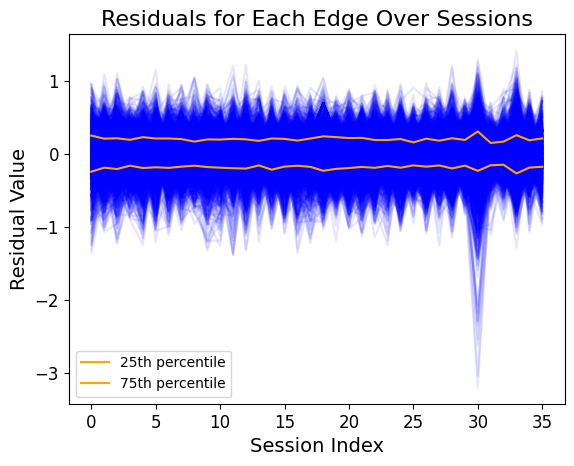

In [39]:
from sklearn.linear_model import LinearRegression

# Calculate the interquartile range (IQR)
q1 = np.percentile(residuals, 25, axis=0)
q3 = np.percentile(residuals, 75, axis=0)
print(q1.shape)
print(q3.shape)

# Plot the evolution of the residual for each edge
for i in range(residuals.shape[0]):
    plt.plot(range(residuals.shape[1]), residuals[i,:], color='blue', alpha=0.1)

# Plot the inter-quartile
plt.plot(range(residuals.shape[1]), q1, color='orange', label='25th percentile')
plt.plot(range(residuals.shape[1]), q3, color='orange', label='75th percentile')


plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.title('Residuals for Each Edge Over Sessions', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend()
plt.show()

#Retrieve confounds in the issues of the github repository

In [40]:
# GitHub repository details
repo_owner = 'TheAxonLab'  # Replace with your GitHub username or org name
repo_name = 'hcph-mood-quest'
# Read token from token.txt
with open('token.txt', 'r') as file:
    token = file.read().strip()

# GitHub API headers
headers = {
    'Authorization': f'token {token}',
    'Accept': 'application/vnd.github.v3+json'
}

# Regular expression to match issue titles with the optional [BEFORE] tag and confounds of interest
issue_title_pattern = r'\[MOOD\](?:\[BEFORE\])? sub-001_ses-0\d{2}'
scan_time_pattern = r'### Scan time\s+(\d{2}-\d{2})'
scan_date_pattern = r'### Scan date\s+(\d{2}-\d{2}-\d{4})'
caffeine_2h_pattern = r'### Caffeine intake in the last 2h \(# cups\)\s+(\d+)'
caffeine_24h_pattern = r'### Caffeine intake in the last 24h \(# cups\)\s+(\d+)'

def get_confounds_in_issues():
    data = []
    page = 1

    while True:
        url = f'https://api.github.com/repos/{repo_owner}/{repo_name}/issues'
        params = {'state': 'all', 'per_page': 100, 'page': page}
        response = requests.get(url, headers=headers, params=params)
        issues = response.json()
        
        # Stop if no more issues
        if not issues:
            break

        for issue in issues:
            title = issue['title']
            if re.search(issue_title_pattern, title):
                # Get the issue body
                issue_body = issue['body']

                # Extract scan time, and confounds of interest
                scan_time = re.search(scan_time_pattern, issue_body)
                scan_date = re.search(scan_date_pattern, issue_body)
                caffeine_2h = re.search(caffeine_2h_pattern, issue_body)
                caffeine_24h = re.search(caffeine_24h_pattern, issue_body)

                # Get the day of the week from scan date
                day_of_week = None
                if scan_date:
                    date_str = scan_date.group(1)
                    date_obj = datetime.strptime(date_str, '%m-%d-%Y')
                    day_of_week = date_obj.strftime('%A')  # Get day name, e.g., 'Monday'
                
                data.append({
                    'IssueTitle': title,
                    'ScanTime': scan_time.group(1) if scan_time else None,
                    'DayofWeek': day_of_week,
                    'CaffeineIntake2h': int(caffeine_2h.group(1)) if caffeine_2h else None,
                    'CaffeineIntake24h': int(caffeine_24h.group(1)) if caffeine_24h else None
                })
        
        page += 1

    return pd.DataFrame(data)

# Retrieve scan times
confounds_df = get_confounds_in_issues()

print(confounds_df)

TypeError: string indices must be integers, not 'str'